# Support Vector Machines

Support vector machines (SVMs) are a powerful and flexible class of supervised algorithms for both classification and regression tasks. The goal of this section is to help develop the intuition behind support vector machines and their use in classification problems.

As usual, we begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

In the previous section we discussed naive Bayes classification, which uses generative models to probabilistically determine labels for new points. That was an example of _generative classification_; here we will consider instead _discriminative classification_: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task where the two classes of points are well separated:

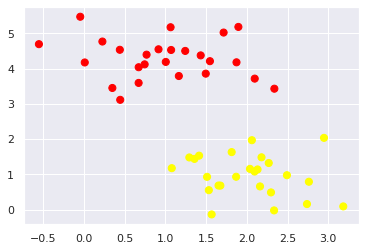

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, creating a model for classification. But there is a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes:

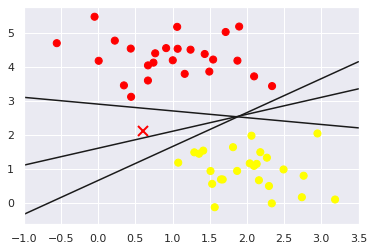

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three very different separators which, for this particular training data, are able to perfectly discriminate between these samples. Depending on which we choose, a new data point (e.g. the one marked by the red "X" in this plot) will be assigned a different label. It should be pretty evident that the simple intuition of "drawing a line between classes" is not enough, and we need to think deeper.

## Support Vector Machines: Maximizing the _Margin_

Support vector machines offer one way to improve this. We can draw around each line a _margin_ of some width, up to the nearest point. Here is an example of how this might look:

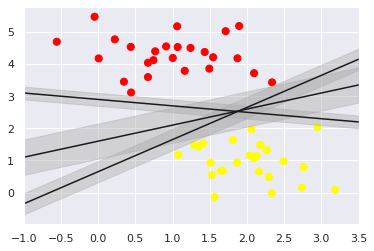

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In SVMs, the line that maximizes the margin is the one we'll choose as the optimal model. SVMs are an example of such a _maximum margin_ estimator.

### Fitting a support vector machine

Let's explore the result of an actual fit to this data. We will use Scikit-Learn's support vector classifier to train an SVM model on this data. For now, we will use a linear kernel and set the `C` parameter to a very large number:

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1e10)
model.fit(X, y)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

We'll use a convenience function that will plot SVM decision boundaries for us:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

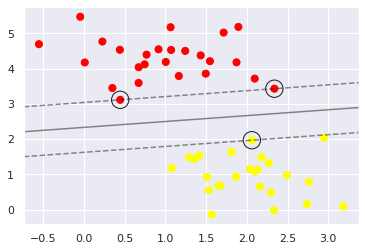

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two classes. Notice that are a few points that just touch the margin: they are indicated by black circles in this figure. These points are the pivotal elements of this fit, and are known as _support vectors_. The identity of these points are stored in the `support_vectors_` attribute of the classifier:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

One important thing to note here is that only the position of the support vectors matter; any points further away from the margin which are on the correct side do not modify the fit! Such points do not contribute to the loss function used to fit this model, so their position and number do not matter so long as they do not cross the margin.

We can clearly see this if we plot the model learned from the first 60 points and first 120 points of the dataset:

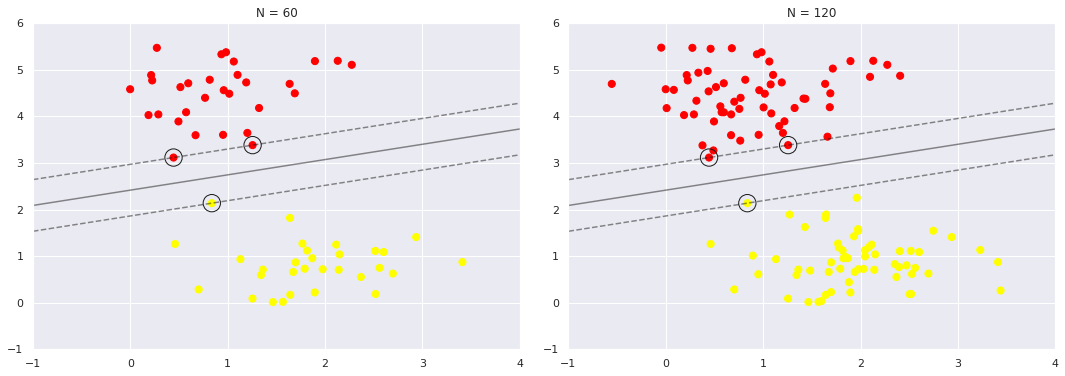

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

We can observe that, despite the increase of data points, the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

### Beyond linear boundaries: Kernel SVM

SVM becomes extremely powerful when it is combined with _kernel_. We have seen a version of kernels before, in the basis function regressions of [Linear Regression](06-LinearRegression.ipynb). There we project our data into higher-dimensional spaces defined by basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier. To motivate the need for kernels, let's look at some data that is not linearly separable:

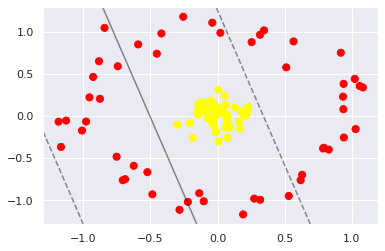

In [10]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is pretty evident that no linear discrimination will _ever_ be able to separate this data. However, we can think about how we might project this data into a higher dimensions such that a linear separator _would_ be sufficient. For example, one simple projection we could use would be to compute a _radial basis function_ centered on the middle clump:

In [11]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot:

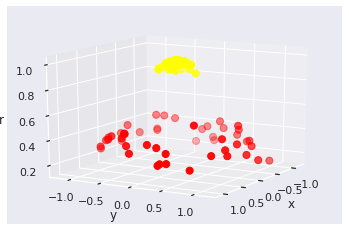

In [12]:
from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed

def plot_3D(elev=30, azim=30, X=X, y=y):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[15, 90], azip=(40, 180),
         X=fixed(X), y=fixed(y));

We can see that with this additional dimension, the data becomes trivially linearly separable.

If we had not centered our radial basis function in the right location, we would not have such linearly separable results. In general, the need to tune such a projection is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to achieve this is to compute a basis function centered at _every_ point in the dataset, and let the SVM sift through the results. This type of basis function transformation is known as _kernel_ transformation, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy (projecting $N$ points into $N$ dimensions) is that it might become very computationally intensive, and perhaps even intractable, as $N$ grows large. However, thanks to a neat little procedure known as [_kernel trick_](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly, without ever building the full $N$-dimensional representation of the kernel projection. This kernel trick is built into the SVM, and is part of the reason why the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM by changing our linear kernel to an RBF (radial basis function) kernel, using the `kernel` model hyperparamter:

In [13]:
clf = SVC(kernel='rbf', C=1e6)
clf.fit(X, y)

SVC(C=1000000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

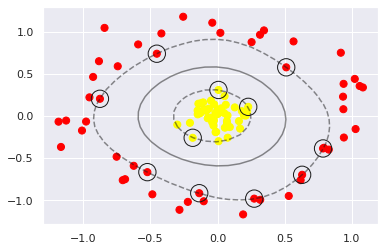

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

This kernel transformation strategy is often used in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

We focused so far around very clear datasets, in which a perfect decision boundary exists. But what if the data has some amount of overlap? For example, consider this data:

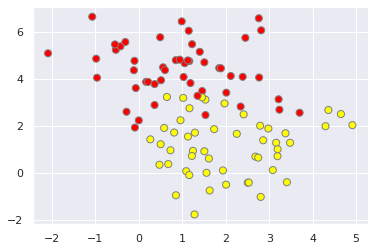

In [15]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolors='gray');

To handle this, the SVM implementation has a factor which "softens" the margin: that is, allows some of the points to creep into the margin if that allows a better fit. The "hardness" of the margin is controlled by the tuning parameter most often known as $C$. For very large $C$, the points cannot lie inside the margin. For smaller $C$, the margin can grow to encompass some points.

The plot shown below gives a visual picture of how changing the $C$ parameter can affect the final fit, via the "softening" of the margin:

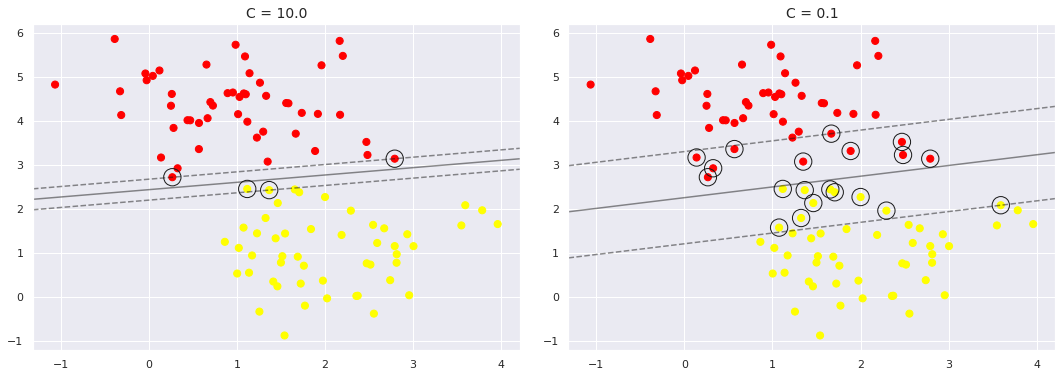

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value for $C$ depends on the dataset, and should be fine tuning using cross-validation or a similar procedure.

## Example: Face Recognition

Let's take a look at the facial recognition problem as an example of support vector machines in action. We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures. Scikit-Learn includes a fetcher for this dataset:

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

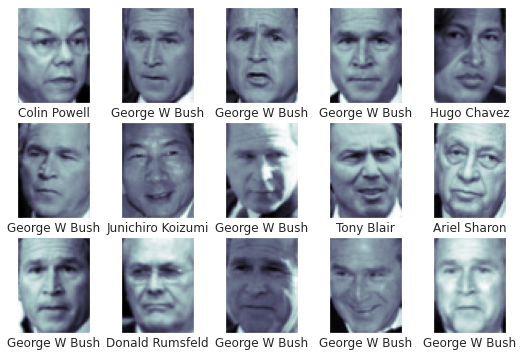

In [18]:
fig, ax = plt.subplots(3, 5, figsize=(9, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image is of the size $62 \times 47$, containing nearly 3000 pixels. Instead of using each pixel value as a feature, we will use some preprocessing to extract more meaningful features, which is often more effective. Here we will use a principal component analysis (PCA) to extract 150 fundamental components to feed into our support vector machine classifier. We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [19]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

We will also split the data into a training and testing set:

In [20]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore a range of combinations of parameters. Here we will adjust `C` (which controls the margin hardness) and `gamma` (which controls the size of the radial basis function (RBF) kernel), and determine the best model:

In [21]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 13s, sys: 36.8 s, total: 1min 50s
Wall time: 42.4 s
{'svc__C': 10, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

We can now predict the labels for the test data:

In [22]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test image along with their predicted values:

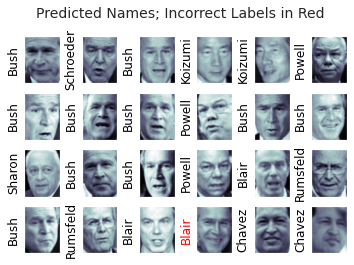

In [23]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

We can see that out of this small sample, our estimator mislabeled only a single face. We can get a much better sense of our estimator's performance using the classification report, which list recovery statistics for each class:

In [24]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



The confusion matrix is another useful resource here:

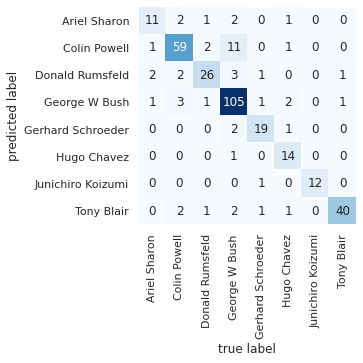

In [25]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us visualize which classes are likely to be confused by the estimator.